# Development 


## 2D to 3D  

### Primary Focus: Tomographic Reconstruction   
### Application: Tomographic Reconstruction of STEM tilt series

#### Challenge: Evaluation with missing ground truth    
#### Required Labels: None

TL;DR 🧬✨ We use deep learning for tomographic reconstruction of 2D STEM projections, following [1,2]. This approach enables 3D volume reconstruction, revealing detailed cellular structures and relationships not visible in 2D.

![Teaser](./images/Teaser.gif)

---

[1] Kniesel, Hannah, et al. "Clean implicit 3D structure from noisy 2D STEM images." Proceedings of the IEEE/CVF Conference on Computer Vision and Pattern Recognition. 2022.

[2] Mildenhall, Ben, et al. "Nerf: Representing scenes as neural radiance fields for view synthesis." Communications of the ACM 65.1 (2021): 99-106.

---



This notebook allows you to do: 

- ✅ **Model Training**: Model training involves optimizing a neural network on a given dataset to learn meaningful patterns, resulting in a trained model that can be used for Evaluation or Inference.  

    - ✅ **Hyperparameter Search**: Before full model training, it is recommended to perform a hyperparameter search. This involves multiple short training runs on different hyperparameter sets to approximate full training performance. The best-performing set is then selected. Expanding the search space or using better approximations can improve results but requires more time and compute resources. Make sure you have enough Lightning AI credits before doing so.  

    - ✅ **Model Training + Validation**: Once the best hyperparameters are selected, the model is trained on the dataset while monitoring performance on a validation set. This ensures that the model generalizes well and helps prevent overfitting.  

- ✅ **Evaluation**: Evaluation assesses the performance of a trained model. This can be done on the test split of the training dataset (this should usually be done after training the model) or on a completely new dataset to check generalization. To evaluate on the full dataset, enable the "evaluate on full" checkbox before running the evaluation cell, only do this if you did not train the model on the same data.  


---


# Setup and Imports

> *Execute the cell below to import external libraries, which simplify the implementation of the notebook.*

In [1]:
# auto reload imports
%load_ext autoreload
%autoreload 2

# imports from the template 
from deepEM.Utils import create_text_widget, print_info, find_file, create_checkbox_widget
from deepEM.Logger import Logger
from deepEM.ModelTuner import ModelTuner

# costum implementation
from src.ModelTrainer import ModelTrainer


# import all required libraries
import os


# 1. Data

## 1.1 Data Acquisition  

In the case of tomographic reconstruction we do not have access to ground truth information (the 3D structure of the underlying sample). Still, it is important to verify the applicability of the deep learning method. Hence, the use of synthetic data to prove the correctness of the approach and estimate errors. 
Luckily, we do not need to generate data from scratch, but we can make use of existing synthetic data [1].

*[1] Kniesel, Hannah, et al. "Clean implicit 3d structure from noisy 2d stem images." Proceedings of the IEEE/CVF Conference on Computer Vision and Pattern Recognition. 2022.*

## 1.2. Data Anntation

The applied deep learning method for tomographic reconstruction is a self-supervised appraoch, which means that we do not need annotated data during training of the neural network. 
Similarly, as we are working with synthetic data, no annotated data is needed for the evaluation.

## 1.3. Data Preprocessing

If you wish to reconstruct your own tomogram using the provided notebook, these are the preprocessing steps you need to do:

1. **Data Alignment**: As there are usually very small deviations of the image alignment between different acquistion angles, the data should be aligned before reconstruction. While [ImageJ](https://imagej.net/ij/) provides data alignment using SIFT, we usually recommend to use more sophisticated approaches like the tracking of gold particles for alignment (for example by using [iMOD](https://bio3d.colorado.edu/imod/)), to get the best results.

2. **Tilt Axis Correction**: In some cases, the tilt axis can be slightly tilted off the main central vertical axis. This needs to be corrected before applying the reconstruction algorithm.
Additionally, we require the tilt axis to be vertical. When a horizontal tilt axis is provided, software like [ImageJ](https://imagej.net/ij/) can be used to rotate the images.



## 1.4. Data Structuring

We require the data to be organized in a single folder containing a series of `.tif` files, which are sorted by their names. 

The folder further needs to contain a `.rawtlt` file with the tilt angles of the EM, again these angles need to be sorted according to the EM image names. When the data is currently in `.mrc` file format, this can be achieved by using the `mrc2tif` command of the [iMOD](https://bio3d.colorado.edu/imod/) software or by using the [ImageJ](https://imagej.net/ij/) software. 

Lastly, we require a `metadata.json` with following content:

```json 
{
    "slice_thickness_nm": 550,
    "pixelsize_nmperpixel": 1.0,
    "original_px_resolution": 1000
}
```

 - `slice_theickness_nm` is the approximated slice thickness of your sample in [nm]. 
 - `pixelsize_nmperpixel` is the pixelsize of your dataset in [nm/px]. 
 - `original_px_resolution` is the image resolution of a single `.tif` in your tilt series in [px]. 


You can generate such file, within any text editor of your choice. Add the above lines of content and adapt the parameters based on your data. Save the file as `metadata.json`. 


### Synthetic Data
Due to the missing ground truth information on real data, the approach should be first trained and tested on synthetic data. The synthetic data consists of a noisy tilt series, which is used for training and a clean tilt series which is used for evaluation. Additionally, we use the phantom volume (hence the ground truth underlying sample of the synthetic data) for evaluation purposes. The data is originally from [1].

An example with a tilt series of five EM images and the corresponding `.rawtlt` and `metadata.json` is shown below: 



```
data/
├── noisy-projections
    ├── image_001.tif
    ├── image_002.tif
    ├── image_003.tif
    ├── image_004.tif
    ├── image_005.tif
    ├── metadata.json
    └── tilts.rawtlt
├── clean-projections
    ├── image_001.tif
    ├── image_002.tif
    ├── image_003.tif
    ├── image_004.tif
    ├── image_005.tif
    ├── metadata.json
    └── tilts.rawtlt
└── phantom-volume
    └── volume.raw

```
For details please check the provided data (`data/real`) within this use case.

### Real Data

If you wish to generate a tomogram from your own tilt series, you can do so, by training the model on the real data. Please note, that due to the special nature of this use case, you will need to train individual models for each tomogram you wish to generate. 
The datastructure for the real data is similar to the synthetic data, but without a folder for `clean-projections` and the `phantom-volume`. An example structure can be seen below: 

```
data/
├── noisy-projections
    ├── image_001.tif
    ├── image_002.tif
    ├── image_003.tif
    ├── image_004.tif
    ├── image_005.tif
    ├── metadata.json
    └── tilts.rawtlt

```
Please note, that the data **needs** to be stored within a folder called `noisy-projections`. The parent folder (in the example above called `data`) can be named arbitrarily. For details please check the provided data (`data/real`) within this use case.

> *Execute the cell below to show a text form. Within this text form you need to define the path to your training data (i.e. `data/synthetic/` or `data/real/`).*


In [2]:
data_widget = create_text_widget("Data Path:","./data/synthetic","Enter the path to your data folder.")
display(*data_widget)

Text(value='./data/synthetic', description='Data Path:', layout=Layout(width='1000px'), style=TextStyle(descri…

HTML(value='<b>Hint:</b> Enter the path to your data folder.')

> *Execute the cell below to set and check the provided Data Path from the text form above.*

In [3]:
data_path = data_widget[0].value
print(f"[INFO]::Data path was set to: {data_path}")

[INFO]::Data path was set to: ./data/synthetic


# 2. Model Training

## 2.1. Setup Logging

By executing the cell below, we setup the logging directory for the hyperparameter search, model training and evaluation. 
The logger creates a folder at `./logs/<datafoldername>-<currentdatetime>/`. 

For each training run there will be one subfolder within the log directory. Training runs of hyperparameter sweeps are called `Sweep_<idx>`, while the subfolder of the final training run is called `TrainingRun`. During evaluation there will be one more subfolder created called `Evaluate`. 

Within each subfolder folder there will be logging of: 

- the used hyperparameters, (`<log-path>/<subfolder>/hyperparameters.json`)
- the best performing model checkpoint based on the validation loss (`<log-path>/<subfolder>/checkpoints/best_model.pth`)
- the last model checkpoint (`<log-path>/<subfolder>/checkpoints/latest_model.pth`)
- visualizations of training and validation curves (`<log-path>/<subfolder>/plots/training_curves.png`)
- qualitative visualization of sampled validation images (`<log-path>/<subfolder>/samples/`)
- results on test metrics (`<log-path>/<subfolder>/test_results.txt`)
- qualitative visualization of sampled test images (`<log-path>/<subfolder>/samples/`)


Sample visualizations of this use case include the model input, validation labels, predictions, and a GradCAM overlay. GradCAM can be interpreted as an heat map, giving an intuition about "where the model looks" to make its prediction.

Visualization of training and validation curves will also be shown after every successful training run within this notebook. They can help to identify possible issues like overfitting during training. For more details, we refer to [this guide](https://www.kaggle.com/code/ryanholbrook/overfitting-and-underfitting).

> *Exectue the cell below to setup the logger. **Hint** If you wish to train a new model, you can reexecute this cell, to generate a new log directory - allowing you to now override the previousely trained model.*


In [4]:
logger = Logger(data_path)

2025-04-03 06:33:11,436 - INFO - Logger initialized. Logs will be saved to: logs/synthetic_2025-04-03_06-33-11


## 2.2. Hyperparameter Tuning

Hyperparameters in deep learning control how a model is trained. Unlike learned model parameters, they are set before training. Hyperparameter tuning explores different configurations by training the model multiple times and selecting the best-performing settings based on validation performance. Since this process is time- and resource-intensive, training runs are often limited in duration or dataset size.

Our playground automates hyperparameter search using grid search, testing all possible combinations of selected hyperparameters. The search space is initially defined by deep learning (DL) experts, who also provide explanations so electron microscopy (EM) specialists can refine it as needed. In order to do so, you can adapt the form below. Each sweep hyperparameter should be separated by `,`. Floating point values should be written like `0.1`. 
Logging estimates the remaining time for individual runs and the full sweep, though early estimates may be inaccurate.

While not strictly required, a hyperparameter search should be performed at least once per dataset to ensure optimal model performance. Interrupting the search early may yield suboptimal results. The automatic sweep stores tested configurations and the best-performing parameters in the training data directory under `Sweep_Parameters`, allowing reuse for future training, or to resume the sweep if the kernel got interrupted.


> *Execute the cell below to show the form of the hyperparameter search space. **Hint** If you've changed parameters and want to reset them to the defaults, reexecute the cell.*

In [5]:
# hyperparameter search
model_trainer = ModelTrainer(data_path, logger)

hyperparameter_tuner = ModelTuner(model_trainer, data_path, logger)
form = hyperparameter_tuner.create_hyperparameter_widgets()
display(form)


INFO::Found 94 images within tilt series at ./data/synthetic/noisy-projections/*.tif.
INFO::Resized image resolution from (1000, 1000) to (500, 500). Note that strong downscaling can lead to loss of information.
INFO:: tilt angles were loaded from ./data/synthetic/noisy-projections/tilt.rawtlt
INFO::Found 94 images within tilt series at ./data/synthetic/clean-projections/*.tif.
INFO::Resized image resolution from (1000, 1000) to (500, 500). Note that strong downscaling can lead to loss of information.
INFO:: tilt angles were loaded from ./data/synthetic/clean-projections/tilt.rawtlt
INFO::Use 20% for validation, resulting in 18 projection images.
INFO::Found 94 images within tilt series at ./data/synthetic/clean-projections/*.tif.
INFO::Resized image resolution from (1000, 1000) to (500, 500). Note that strong downscaling can lead to loss of information.
INFO:: tilt angles were loaded from ./data/synthetic/clean-projections/tilt.rawtlt
INFO::Use 100% for validation, resulting in 94 pro

> *If you wish to run a hyperparameter sweep based on the parameters above, please execute the cell below. This should be done at least once per dataset. Note that this can take a while. We recomment to set resize to a smaller value (i.e. 100) during hyperparameter search to save resources.*

2025-04-02 06:28:40,333 - INFO - Start hyperparameter sweep...
2025-04-02 06:28:40,334 - INFO - Found sweep log with current best parameters: {'learning_rate': 0.0005, 'batch_size': 4, 'resize': 100}
2025-04-02 06:28:40,337 - INFO - Logger initialized. Logs will be saved to: logs/synthetic_2025-04-02_06-27-45/Sweep_0
2025-04-02 06:28:40,337 - INFO - Start Sweep 1 of 6...
2025-04-02 06:28:40,338 - INFO - Current hyperparams {'learning_rate': 0.0005, 'accum_gradients': 4, 'resize': 100}
2025-04-02 06:28:40,340 - INFO - Hyperparameters saved to logs/synthetic_2025-04-02_06-27-45/Sweep_0/hyperparameters.json


Train subset: 0.2
INFO::Found 94 images within tilt series at ./data/synthetic/noisy-projections/*.tif.
INFO::Resized image resolution from (1000, 1000) to (100, 100). Note that strong downscaling can lead to loss of information.
INFO:: tilt angles were loaded from ./data/synthetic/noisy-projections/tilt.rawtlt
INFO::Found 94 images within tilt series at ./data/synthetic/clean-projections/*.tif.
INFO::Resized image resolution from (1000, 1000) to (100, 100). Note that strong downscaling can lead to loss of information.
INFO:: tilt angles were loaded from ./data/synthetic/clean-projections/tilt.rawtlt
INFO::Use 20% for validation, resulting in 18 projection images.
INFO::Found 94 images within tilt series at ./data/synthetic/clean-projections/*.tif.
INFO::Resized image resolution from (1000, 1000) to (100, 100). Note that strong downscaling can lead to loss of information.
INFO:: tilt angles were loaded from ./data/synthetic/clean-projections/tilt.rawtlt
INFO::Use 100% for validation, r

[Training Run] | Num Epochs: 6 | Dataset size: 188000:   0%|          | 0/6 [00:00<?, ?it/s]/mnt/hdd/hannah/DeepEM-Tomography/src/STEM.py:80: UserWarning: The torch.cuda.*DtypeTensor constructors are no longer recommended. It's best to use methods such as torch.tensor(data, dtype=*, device='cuda') to create tensors. (Triggered internally at ../torch/csrc/tensor/python_tensor.cpp:78.)
  offset = torch.cuda.FloatTensor(batch_size, beam_samples*2).uniform_(float(-bin_size/2), float(bin_size/2))
[Training Run] | Num Epochs: 6 | Dataset size: 188000: 100%|██████████| 6/6 [03:50<00:00, 38.38s/it]


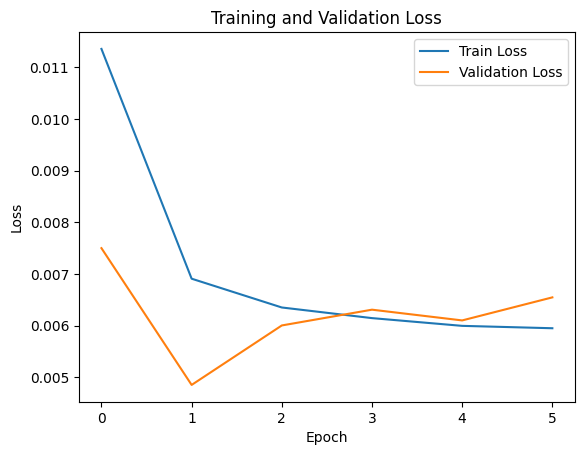

2025-04-02 06:32:43,418 - INFO - Finished training. Find logs and model checkpoints at: logs/synthetic_2025-04-02_06-27-45/Sweep_0

2025-04-02 06:32:43,419 - INFO - Hyperparameters: {'learning_rate': 0.0005, 'accum_gradients': 4, 'resize': 100}, Validation Loss: 0.004851487773995174
2025-04-02 06:32:43,419 - INFO - Avg time single sweep: 0h3m50s | Remaining_time: 0h19m11s
2025-04-02 06:32:43,422 - INFO - Current best sweep parameters were saved to ./data/synthetic/Sweep_Parameters/best_sweep_parameters.json
2025-04-02 06:32:43,425 - INFO - Logger initialized. Logs will be saved to: logs/synthetic_2025-04-02_06-27-45/Sweep_1
2025-04-02 06:32:43,425 - INFO - Start Sweep 2 of 6...
2025-04-02 06:32:43,426 - INFO - Current hyperparams {'learning_rate': 0.0005, 'accum_gradients': 8, 'resize': 100}
2025-04-02 06:32:43,428 - INFO - Hyperparameters saved to logs/synthetic_2025-04-02_06-27-45/Sweep_1/hyperparameters.json


Train subset: 0.2
INFO::Found 94 images within tilt series at ./data/synthetic/noisy-projections/*.tif.
INFO::Resized image resolution from (1000, 1000) to (100, 100). Note that strong downscaling can lead to loss of information.
INFO:: tilt angles were loaded from ./data/synthetic/noisy-projections/tilt.rawtlt
INFO::Found 94 images within tilt series at ./data/synthetic/clean-projections/*.tif.
INFO::Resized image resolution from (1000, 1000) to (100, 100). Note that strong downscaling can lead to loss of information.
INFO:: tilt angles were loaded from ./data/synthetic/clean-projections/tilt.rawtlt
INFO::Use 20% for validation, resulting in 18 projection images.
INFO::Found 94 images within tilt series at ./data/synthetic/clean-projections/*.tif.
INFO::Resized image resolution from (1000, 1000) to (100, 100). Note that strong downscaling can lead to loss of information.
INFO:: tilt angles were loaded from ./data/synthetic/clean-projections/tilt.rawtlt
INFO::Use 100% for validation, r

[Training Run] | Num Epochs: 6 | Dataset size: 188000: 100%|██████████| 6/6 [03:50<00:00, 38.34s/it]


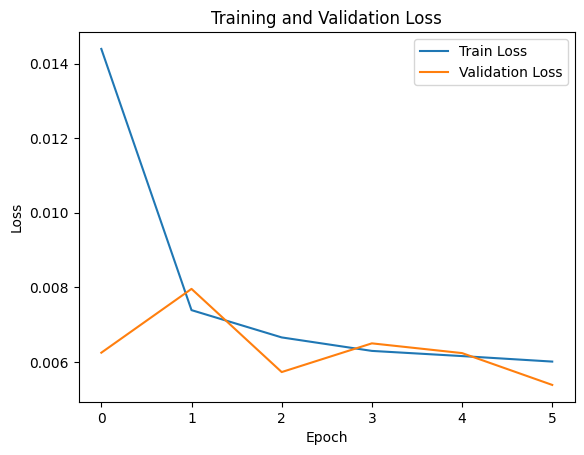

2025-04-02 06:36:37,028 - INFO - Finished training. Find logs and model checkpoints at: logs/synthetic_2025-04-02_06-27-45/Sweep_1

2025-04-02 06:36:37,029 - INFO - Hyperparameters: {'learning_rate': 0.0005, 'accum_gradients': 8, 'resize': 100}, Validation Loss: 0.005383976960514659
2025-04-02 06:36:37,030 - INFO - Avg time single sweep: 0h3m50s | Remaining_time: 0h15m21s
2025-04-02 06:36:37,032 - INFO - Current best sweep parameters were saved to ./data/synthetic/Sweep_Parameters/best_sweep_parameters.json
2025-04-02 06:36:37,034 - INFO - Logger initialized. Logs will be saved to: logs/synthetic_2025-04-02_06-27-45/Sweep_2
2025-04-02 06:36:37,035 - INFO - Start Sweep 3 of 6...
2025-04-02 06:36:37,035 - INFO - Current hyperparams {'learning_rate': 5e-05, 'accum_gradients': 4, 'resize': 100}
2025-04-02 06:36:37,037 - INFO - Hyperparameters saved to logs/synthetic_2025-04-02_06-27-45/Sweep_2/hyperparameters.json


Train subset: 0.2
INFO::Found 94 images within tilt series at ./data/synthetic/noisy-projections/*.tif.
INFO::Resized image resolution from (1000, 1000) to (100, 100). Note that strong downscaling can lead to loss of information.
INFO:: tilt angles were loaded from ./data/synthetic/noisy-projections/tilt.rawtlt
INFO::Found 94 images within tilt series at ./data/synthetic/clean-projections/*.tif.
INFO::Resized image resolution from (1000, 1000) to (100, 100). Note that strong downscaling can lead to loss of information.
INFO:: tilt angles were loaded from ./data/synthetic/clean-projections/tilt.rawtlt
INFO::Use 20% for validation, resulting in 18 projection images.
INFO::Found 94 images within tilt series at ./data/synthetic/clean-projections/*.tif.
INFO::Resized image resolution from (1000, 1000) to (100, 100). Note that strong downscaling can lead to loss of information.
INFO:: tilt angles were loaded from ./data/synthetic/clean-projections/tilt.rawtlt
INFO::Use 100% for validation, r

[Training Run] | Num Epochs: 6 | Dataset size: 188000: 100%|██████████| 6/6 [03:51<00:00, 38.51s/it]


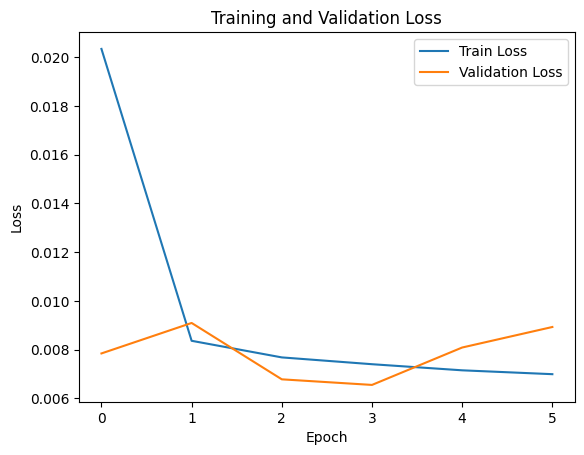

2025-04-02 06:40:31,596 - INFO - Finished training. Find logs and model checkpoints at: logs/synthetic_2025-04-02_06-27-45/Sweep_2

2025-04-02 06:40:31,597 - INFO - Hyperparameters: {'learning_rate': 5e-05, 'accum_gradients': 4, 'resize': 100}, Validation Loss: 0.006550130224637713
2025-04-02 06:40:31,598 - INFO - Avg time single sweep: 0h3m50s | Remaining_time: 0h11m31s
2025-04-02 06:40:31,601 - INFO - Current best sweep parameters were saved to ./data/synthetic/Sweep_Parameters/best_sweep_parameters.json
2025-04-02 06:40:31,603 - INFO - Logger initialized. Logs will be saved to: logs/synthetic_2025-04-02_06-27-45/Sweep_3
2025-04-02 06:40:31,603 - INFO - Start Sweep 4 of 6...
2025-04-02 06:40:31,604 - INFO - Current hyperparams {'learning_rate': 5e-05, 'accum_gradients': 8, 'resize': 100}
2025-04-02 06:40:31,606 - INFO - Hyperparameters saved to logs/synthetic_2025-04-02_06-27-45/Sweep_3/hyperparameters.json


Train subset: 0.2
INFO::Found 94 images within tilt series at ./data/synthetic/noisy-projections/*.tif.
INFO::Resized image resolution from (1000, 1000) to (100, 100). Note that strong downscaling can lead to loss of information.
INFO:: tilt angles were loaded from ./data/synthetic/noisy-projections/tilt.rawtlt
INFO::Found 94 images within tilt series at ./data/synthetic/clean-projections/*.tif.
INFO::Resized image resolution from (1000, 1000) to (100, 100). Note that strong downscaling can lead to loss of information.
INFO:: tilt angles were loaded from ./data/synthetic/clean-projections/tilt.rawtlt
INFO::Use 20% for validation, resulting in 18 projection images.
INFO::Found 94 images within tilt series at ./data/synthetic/clean-projections/*.tif.
INFO::Resized image resolution from (1000, 1000) to (100, 100). Note that strong downscaling can lead to loss of information.
INFO:: tilt angles were loaded from ./data/synthetic/clean-projections/tilt.rawtlt
INFO::Use 100% for validation, r

[Training Run] | Num Epochs: 6 | Dataset size: 188000: 100%|██████████| 6/6 [03:49<00:00, 38.20s/it]


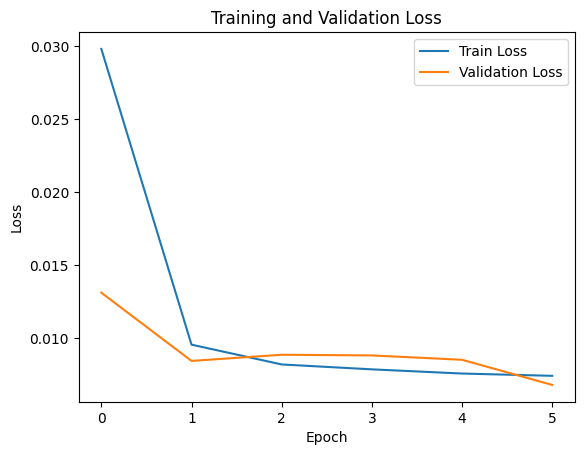

2025-04-02 06:44:24,326 - INFO - Finished training. Find logs and model checkpoints at: logs/synthetic_2025-04-02_06-27-45/Sweep_3

2025-04-02 06:44:24,327 - INFO - Hyperparameters: {'learning_rate': 5e-05, 'accum_gradients': 8, 'resize': 100}, Validation Loss: 0.006773965573285955
2025-04-02 06:44:24,327 - INFO - Avg time single sweep: 0h3m50s | Remaining_time: 0h7m40s
2025-04-02 06:44:24,330 - INFO - Current best sweep parameters were saved to ./data/synthetic/Sweep_Parameters/best_sweep_parameters.json
2025-04-02 06:44:24,332 - INFO - Logger initialized. Logs will be saved to: logs/synthetic_2025-04-02_06-27-45/Sweep_4
2025-04-02 06:44:24,333 - INFO - Start Sweep 5 of 6...
2025-04-02 06:44:24,333 - INFO - Current hyperparams {'learning_rate': 5e-06, 'accum_gradients': 4, 'resize': 100}
2025-04-02 06:44:24,335 - INFO - Hyperparameters saved to logs/synthetic_2025-04-02_06-27-45/Sweep_4/hyperparameters.json


Train subset: 0.2
INFO::Found 94 images within tilt series at ./data/synthetic/noisy-projections/*.tif.
INFO::Resized image resolution from (1000, 1000) to (100, 100). Note that strong downscaling can lead to loss of information.
INFO:: tilt angles were loaded from ./data/synthetic/noisy-projections/tilt.rawtlt
INFO::Found 94 images within tilt series at ./data/synthetic/clean-projections/*.tif.
INFO::Resized image resolution from (1000, 1000) to (100, 100). Note that strong downscaling can lead to loss of information.
INFO:: tilt angles were loaded from ./data/synthetic/clean-projections/tilt.rawtlt
INFO::Use 20% for validation, resulting in 18 projection images.
INFO::Found 94 images within tilt series at ./data/synthetic/clean-projections/*.tif.
INFO::Resized image resolution from (1000, 1000) to (100, 100). Note that strong downscaling can lead to loss of information.
INFO:: tilt angles were loaded from ./data/synthetic/clean-projections/tilt.rawtlt
INFO::Use 100% for validation, r

[Training Run] | Num Epochs: 6 | Dataset size: 188000: 100%|██████████| 6/6 [03:51<00:00, 38.56s/it]


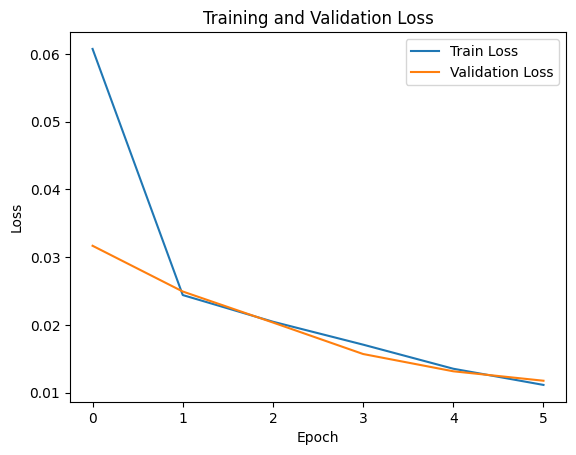

2025-04-02 06:48:19,143 - INFO - Finished training. Find logs and model checkpoints at: logs/synthetic_2025-04-02_06-27-45/Sweep_4

2025-04-02 06:48:19,144 - INFO - Hyperparameters: {'learning_rate': 5e-06, 'accum_gradients': 4, 'resize': 100}, Validation Loss: 0.011749728238229947
2025-04-02 06:48:19,144 - INFO - Avg time single sweep: 0h3m50s | Remaining_time: 0h3m50s
2025-04-02 06:48:19,147 - INFO - Current best sweep parameters were saved to ./data/synthetic/Sweep_Parameters/best_sweep_parameters.json
2025-04-02 06:48:19,149 - INFO - Logger initialized. Logs will be saved to: logs/synthetic_2025-04-02_06-27-45/Sweep_5
2025-04-02 06:48:19,149 - INFO - Start Sweep 6 of 6...
2025-04-02 06:48:19,150 - INFO - Current hyperparams {'learning_rate': 5e-06, 'accum_gradients': 8, 'resize': 100}
2025-04-02 06:48:19,152 - INFO - Hyperparameters saved to logs/synthetic_2025-04-02_06-27-45/Sweep_5/hyperparameters.json


Train subset: 0.2
INFO::Found 94 images within tilt series at ./data/synthetic/noisy-projections/*.tif.
INFO::Resized image resolution from (1000, 1000) to (100, 100). Note that strong downscaling can lead to loss of information.
INFO:: tilt angles were loaded from ./data/synthetic/noisy-projections/tilt.rawtlt
INFO::Found 94 images within tilt series at ./data/synthetic/clean-projections/*.tif.
INFO::Resized image resolution from (1000, 1000) to (100, 100). Note that strong downscaling can lead to loss of information.
INFO:: tilt angles were loaded from ./data/synthetic/clean-projections/tilt.rawtlt
INFO::Use 20% for validation, resulting in 18 projection images.
INFO::Found 94 images within tilt series at ./data/synthetic/clean-projections/*.tif.
INFO::Resized image resolution from (1000, 1000) to (100, 100). Note that strong downscaling can lead to loss of information.
INFO:: tilt angles were loaded from ./data/synthetic/clean-projections/tilt.rawtlt
INFO::Use 100% for validation, r

[Training Run] | Num Epochs: 6 | Dataset size: 188000: 100%|██████████| 6/6 [03:50<00:00, 38.34s/it]


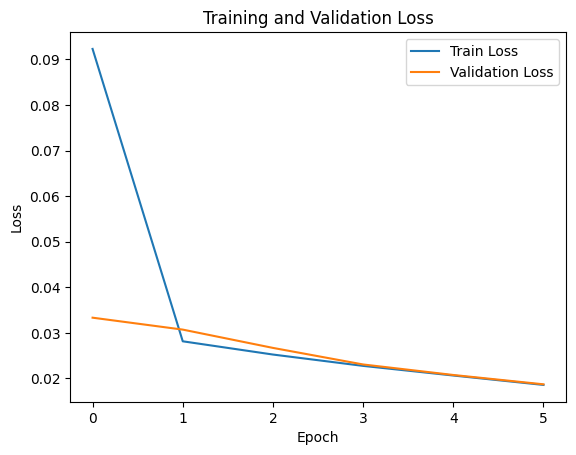

2025-04-02 06:52:12,686 - INFO - Finished training. Find logs and model checkpoints at: logs/synthetic_2025-04-02_06-27-45/Sweep_5

2025-04-02 06:52:12,687 - INFO - Hyperparameters: {'learning_rate': 5e-06, 'accum_gradients': 8, 'resize': 100}, Validation Loss: 0.01870939495921641
2025-04-02 06:52:12,687 - INFO - Avg time single sweep: 0h3m50s | Remaining_time: 0h0m0s
2025-04-02 06:52:12,690 - INFO - Current best sweep parameters were saved to ./data/synthetic/Sweep_Parameters/best_sweep_parameters.json
2025-04-02 06:52:12,690 - INFO - Best Parameters: {'learning_rate': 0.0005, 'batch_size': 4, 'resize': 100}, Best Loss: 0.005785979879251952, Best Sweep index: 0
2025-04-02 06:52:12,691 - INFO - Finished sweep with best validation loss = 0.005785979879251952.
2025-04-02 06:52:12,691 - INFO - Will use these hyperparameters: {'learning_rate': 0.0005, 'batch_size': 4, 'resize': 100}


In [7]:
best_config = None
hyperparameter_tuner.update_config(form)
best_config = hyperparameter_tuner.tune()

Our automatic hyperparameter tuning is able to find the best performing set of hyperparameters based on the setting shown above. 

However, there can be scenarios, where additional flexibility is required. Therefore, you are able to change these hyperparameters in the following. 

> *Execute the cell below to show and possibly adapt the currently chosen hyperparameters. We recomment to set resize to a higher value (i.e. 500) for final training to reduce information loss.*

In [6]:
form = hyperparameter_tuner.edit_hyperparameters()
display(form)

Additionally, you can increase or decrease the number of training epochs. An 'epoch' in deep learning is one full pass of the model through all the training data, where the model learns and adjusts to improve its predictions. Higher number of epochs leads to longer training but can further improve model performance.

> *Execute the cell below to show and possibly adapt the number of training epochs. Leave as is, if you want to train with the suggestion of the DL expert.*

In [7]:
model_trainer.reduce_epochs = None
model_trainer.set_epochs()
epochs_widget = create_text_widget("Epochs:",str(model_trainer.num_epochs),"Higher number of epochs leads to longer training but can further improve model performance.")
display(*epochs_widget)

Text(value='25', description='Epochs:', layout=Layout(width='1000px'), style=TextStyle(description_width='init…

HTML(value='<b>Hint:</b> Higher number of epochs leads to longer training but can further improve model perfor…

> *Execute the cell below to set the hyperparameters and number of training epochs for your training run, based on the forms above.*

In [8]:
best_config = hyperparameter_tuner.update_hyperparameters(form)
model_trainer.num_epochs = int(epochs_widget[0].value)
print_info(f"Will use following hyperparameters for future training: {best_config} with number of epochs: {model_trainer.num_epochs}.")

[INFO]::Will use following hyperparameters for future training: {'learning_rate': 0.0005, 'accum_gradients': 4, 'resize': 500} with number of epochs: 25.


## 2.3. Training and Validation

In this section we train and validate the model based on the provided data and hyperparameters resulting from the previous sweep.

Training in deep learning is the process where a model learns patterns from labeled data (the one provided at the top of this notebook) by optimizing its parameters through backpropagation. 
Validation involves using a separate dataset to evaluate the model's performance during training, ensuring it generalizes well to unseen data.

Training and validating a model can take a lot of time (ranging from minutes to hours, days or even weeks) depending on the model, the training procedure and the dataset. Our logging module provides approximate times for training, which you can see below the executed training cell or at the `log.txt` within the current log directory (i.e. `<log-dir>/TrainingRun/`). However, these times can be inaccurate, especially at the beginning of training. 

### Model Checkpoint
In the following you can provide a model checkpoint for training. There are two different scenarios when you might want to provide a model checkpoint:

1. You wish to resume training. This means, training will picks up exactly where it left off, including learned patterns and settings. This is useful if training was interrupted and needs to be finished from the last saved state. To do so, you need to provide a model checkpoint in the text form below. You can find the last saved checkpoint inside the runs logging directory (`<log-dir>/TrainingRun/checkpoints/latest_model.pth`).
2. If you wish to finetune your model. Fine-tuning starts training from the beginning (epoch 0) but uses a pre-trained model as a starting point, already having knowledge about some previousely learned patterns, to improve its performance on a new task or dataset. You can find the best model checkpoint inside the runs logging directory (`<log-dir>/TrainingRun/checkpoints/best_model.pth`).

If you wish to finetune the model, you need to check the checkbox below. If you only provide the path to a directory, it will look for a `best_model.pth` or `latest_model.pth` accordingly, within this directory.


If you want to start training from scratch (which is usually the case), you can leave the text form below empty.

> *Execute the cell below to show a text form. If you wish to resume training, or do finetuning you need to provide a path to a model checkpoint. Leave it empty for standard training.*

In [9]:
resume_widget = create_text_widget("Model Checkpoint Path:","","If you wish to resume an earlier training, or do finetuning, enter the path to the latest_model.pth or the best_model.pth file here.")
checkbox_widget, description_widget = create_checkbox_widget(
    name="Enable Finetuning",
    value=False,
    description="Check this box to do finetuning based on the provided model checkpoint above. This means, the models weights will be used for initializing the model, training will be then done as usual."
)
display(*resume_widget, checkbox_widget, description_widget)

Text(value='', description='Model Checkpoint Path:', layout=Layout(width='1000px'), style=TextStyle(descriptio…

HTML(value='<b>Hint:</b> If you wish to resume an earlier training, or do finetuning, enter the path to the la…

Checkbox(value=False, description='Enable Finetuning', style=CheckboxStyle(description_width='initial'))

HTML(value='<b>Hint:</b> Check this box to do finetuning based on the provided model checkpoint above. This me…

> *Execute the cell below to prepare the model and data for training.*

In [10]:
resume_training = resume_widget[0].value
finetuning = checkbox_widget.value
if(resume_training):
    if(os.path.isfile(resume_training)):
        logger.log_info(f"Found model checkpoint at {resume_training}.")

    else: 
        if(not finetuning):
            resume_training = find_file(resume_training, "latest_model.pth")           
        else: 
            resume_training = find_file(resume_training, "best_model.pth")
            
            
        if(resume_training is None):
            logger.log_error(f"Could not find resume path at {resume_widget[0].value}. Will start training from scatch.")
        else: 
            logger.log_info(f"Found model checkpoint at {resume_training}.")

else:
    resume_training = None
logger.init("TrainingRun")
model_trainer.resume_from_checkpoint = resume_training
model_trainer.finetuning = finetuning
model_trainer.prepare(best_config)


2025-04-03 06:34:34,484 - INFO - Logger initialized. Logs will be saved to: logs/synthetic_2025-04-03_06-33-11/TrainingRun
2025-04-03 06:34:34,486 - INFO - Hyperparameters saved to logs/synthetic_2025-04-03_06-33-11/TrainingRun/hyperparameters.json


INFO::Found 94 images within tilt series at ./data/synthetic/noisy-projections/*.tif.
INFO::Resized image resolution from (1000, 1000) to (500, 500). Note that strong downscaling can lead to loss of information.
INFO:: tilt angles were loaded from ./data/synthetic/noisy-projections/tilt.rawtlt
INFO::Found 94 images within tilt series at ./data/synthetic/clean-projections/*.tif.
INFO::Resized image resolution from (1000, 1000) to (500, 500). Note that strong downscaling can lead to loss of information.
INFO:: tilt angles were loaded from ./data/synthetic/clean-projections/tilt.rawtlt
INFO::Use 20% for validation, resulting in 18 projection images.
INFO::Found 94 images within tilt series at ./data/synthetic/clean-projections/*.tif.
INFO::Resized image resolution from (1000, 1000) to (500, 500). Note that strong downscaling can lead to loss of information.
INFO:: tilt angles were loaded from ./data/synthetic/clean-projections/tilt.rawtlt
INFO::Use 100% for validation, resulting in 94 pro

> *Execute the cell below if you wish to **train** a model. Note that this can take a while.* 

[Training Run] | Num Epochs: 25 | Dataset size: 23500000: 100%|██████████| 25/25 [21:18:53<00:00, 3069.33s/it]   


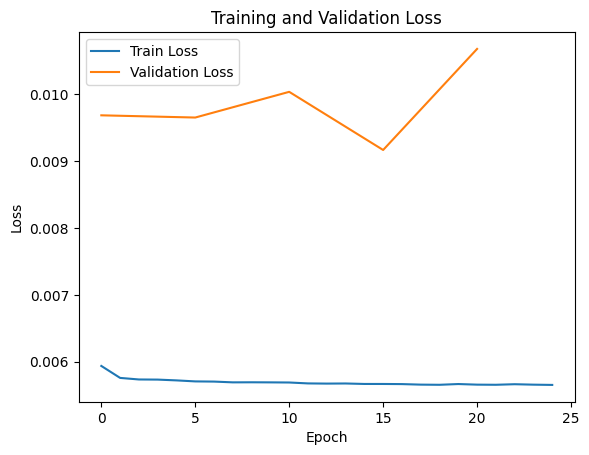

2025-04-03 04:22:35,932 - INFO - Finished training. Find logs and model checkpoints at: logs/synthetic_2025-04-02_06-27-45/TrainingRun



np.float64(0.009167853200809746)

In [13]:
model_trainer.fit()

# 3. Model Evaluation
Evaluation in deep learning is the process of evaluating a trained model on a separate, unseen dataset to measure its final performance. It provides an unbiased assessment of the model's ability to generalize to new data.

## 3.1. Choose Model 

In this section we choose the model for testing. 
If you leave the `Model Path` empty in the text form below, it will use the last model trained.
Otherwise, you can define the path to the models best weights at `<log-path>/TrainingRun/checkpoints/best_model.pth` or by providing a path to a directory, which contains `best_model.pth` (like `<log-path>/TrainingRun/`). This allows you to also test shared models or previousely trained models.

> *Execute the cell below to show the text form for selecting a model for testing.*

In [11]:
model_widget = create_text_widget("Model Path:","","If you wish to test a specific model, you can here define the path to its checkpoint. (For example: logs/tem-herpes_2025-02-03_11-42-43/TrainingRun/checkpoints)")
display(*model_widget)

Text(value='', description='Model Path:', layout=Layout(width='1000px'), style=TextStyle(description_width='in…

HTML(value='<b>Hint:</b> If you wish to test a specific model, you can here define the path to its checkpoint.…

## 3.2. Evaluate
We finally evaluate the provided model on the test set. We investigate following metrics: 

- **Mean Squared Error (MSE)**: A distance metric to compute the squared difference between the prediction and the label. In this use case this means, we compute the difference between the real EM tilt images with the computed EM images based on the learned reconstruction. If MSE is low, the model is able to correctly represent the underlying sample within the tomogram. The lower the metric, the better. 

- **MSE phantom**: The first metric is not able to capture generalizability of the model to unknown tilt angles, as it only computes the MSE on the tilt series which was used for training. But as we are using synthetic data, we do have access to the underlying phantom volume (the synthetic sample used to compute the tilt series). We hence compare the learned sample with this phantom volume, again by computing the MSE. 


#### **Summary**
| Metric  | Meaning | Interpretation |
|---------|---------|---------|
| **MSE**  | Distance between true tilt series and tilt series based on the learned reconstruction. | Lower is better |
| **MSE phantom**  | Distance between the phantom volume (the synthetic sample used to compute the tilt series) and the learned sample (tomogram) | Lower is better | 

Visualizations, at `<log-path>/Evaluate/samples/test_*`, show the real EM tilt images (Ground Truth Micrograph) compared to the computed EM images based on the learned reconstruction (Predicted Micrograph). Additionally, the learned tomogram is saved to `<log-path>/Evaluate/samples/tomogram.tif`



> *If you wish to evaluate a model (recommended), execute the cell below.*

In [13]:
eval_model

PosixPath('logs/synthetic_2025-04-02_06-27-45/Sweep_0/checkpoints/best_model.pth')

In [12]:
from pathlib import Path 
start_evaluation = False
eval_model = model_widget[0].value
if(eval_model):
    eval_model = Path(eval_model)
    if(eval_model.is_dir()):
        eval_model = Path(find_file(eval_model, "best_model.pth")) 
    if(not eval_model.is_file()):
        logger.log_error(f"Could not find model at {eval_model}. Make sure to train a model before evaluation.")
        eval_model = None
    else: 
        start_evaluation = True
else:
    recent_logs = logger.get_most_recent_logs()
    eval_model = ""
    for dataname, log_path in recent_logs.items():
        if(dataname == Path(data_path).stem):
            eval_model = Path(log_path+"/TrainingRun/checkpoints/best_model.pth")
            if(not eval_model.is_file()):
                logger.log_error(f"Could not find a trained model at {eval_model}. Make sure you fully train a model first before evaluating.")
            else:
                logger.log_info(f"Found most recent log at {eval_model}")
                start_evaluation = True
        else: 
            continue
    if(not start_evaluation):
        logger.log_error("Could not find a trained model. Make sure you train a model first before evaluating.")
      
if(start_evaluation):
    evaluate_on_full = False
    model_trainer.logger.init(f"Evaluate")
    model_trainer.logger.init_directories()
    model_trainer.load_checkpoint(eval_model)
    model_trainer.test(evaluate_on_full)      

/mnt/hdd/hannah/DeepEM-Tomography/src/ModelTrainer.py:430: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  checkpoint = torch.load(checkpoint_path)


INFO::Found 94 images within tilt series at ./data/synthetic/noisy-projections/*.tif.
INFO::Resized image resolution from (1000, 1000) to (100, 100). Note that strong downscaling can lead to loss of information.
INFO:: tilt angles were loaded from ./data/synthetic/noisy-projections/tilt.rawtlt
INFO::Found 94 images within tilt series at ./data/synthetic/clean-projections/*.tif.
INFO::Resized image resolution from (1000, 1000) to (100, 100). Note that strong downscaling can lead to loss of information.
INFO:: tilt angles were loaded from ./data/synthetic/clean-projections/tilt.rawtlt
INFO::Use 20% for validation, resulting in 18 projection images.
INFO::Found 94 images within tilt series at ./data/synthetic/clean-projections/*.tif.
INFO::Resized image resolution from (1000, 1000) to (100, 100). Note that strong downscaling can lead to loss of information.
INFO:: tilt angles were loaded from ./data/synthetic/clean-projections/tilt.rawtlt
INFO::Use 100% for validation, resulting in 94 pro

RuntimeError: Parent directory logs/synthetic_2025-04-03_06-33-11/TrainingRun/checkpoints does not exist.

# Whats Next?

## Not satisfied? 
If you are not satisfied with the evaluation performance of your model you have multiple options: 
1. Extend the hyperparameter search by adding more, different hyperparameters - they might work better.
2. Extend the hyperparameter search to a larger data subset or longer training. This will lead to more accurate results of the sweep, but it will require more compute time. 
3. Run multiple training runs with different custom parameters (you can define them right before the cell for training your model).
4. Extend the number of training epochs. Longer training can lead to better performance of the model. To do so, you can again define the number of epochs in the cell right before training the model.
5. Finetune or train the model on your own annotated dataset. To do so, we recomment using CVAT for annotation. A general guide for annotating your data with CVAT can ge found on our ["Getting Started - 4. Data Annotation"](https://viscom-ulm.github.io/DeepEM/getting-started.html). A more specific guide for this use case can be found at the top of this notebook. 
6. Check the training and sweep runs loggings and train/val curves - maybe you found an issue with the training itself?
 
## Satisfied?
If you are satisfied with the results of your trained or evaluated model, there are multiple things to test next:

1. Check the generalizability of your trained model. To do so, you can evaluate your model on different, annotated datasets. Upload your annotated data and define it as `data_path` at the top of this notebook. Check the top of the notebook for data structuring and annotation formats. Run all cells except for `hyperparameter tuning`  and `training`. Then, check the checkbox "evaluate on full dataset" such that all of your uploaded data is considered for evalutation. 
2. Use the trained model for inference. That means using the model on unseen, unlabeled data for the support of your EM data analysis. To do so, open the `2_Inference.ipynb` and follow the steps provided.
3. Share and collaborate with other researchers

Additionally, you can share your training code and model weights with other collegues. An easy way on how to do this can be found on our website under ["Getting Started - 5. Collaboration"](https://viscom-ulm.github.io/DeepEM/getting-started.html).